In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout, Conv2DTranspose, UpSampling2D
from tensorflow.keras import layers, losses
from tensorflow.keras import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
from sklearn.model_selection import train_test_split

from utils.image_formatting import *

%load_ext autoreload
%autoreload 2

In [2]:
X, y = preprocess_images2(artists=list(PAINTER_DICT.keys()), n_imgs=1000, dropout_rate=None)
X_train, X_val, _ , _ = train_test_split(X, y, test_size=0.05)   

print(X_train.shape)
print(X_val.shape)

(5001, 256, 256, 3)
(264, 256, 256, 3)


In [3]:
# 1. input layer: 3 x 256 x 256
# 2. CONV layer: 100 x 256 x 256 (filter: 5 x 5)
# 3. Maxpooling layer: 2 x 2
# 4. CONV layer: 200 x 128 x 128 (filter: 5 x 5)
# 5. Maxpooling layer: 2 x 2
# 6. Lambda layer: -
# 7. Unpooling: 2 x 2
# 8. deCONV layer: 200 x 128 x 128
# 9. Unpooling: 2 x 2
# 10. deCONV layer: 100 x 256 x 256
# 11. reconstruct to the original images
# Purpose: learn the hyperparameter from reconstructing images

CAE = Sequential()
CAE.add(Conv2D(filters=100, kernel_size=(5, 5), strides=(1,1), activation='relu', input_shape=(256, 256, 3), padding='same', name = 'Conv2D_1'))
CAE.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid', name='MaxPool_1'))
CAE.add(Conv2D(filters=200, kernel_size=(5, 5), strides=(1,1), activation='relu', padding='same', name='Conv2D_2'))
CAE.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid', name='MaxPool_2'))
CAE.add(UpSampling2D(interpolation='bilinear', name='UpSample_1'))
CAE.add(Conv2DTranspose(filters=200, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding='same', name='DeConv2D_1'))
CAE.add(UpSampling2D(interpolation='bilinear', name='UpSample_2'))
CAE.add(Conv2DTranspose(filters=100, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding='same', name='De2DTrans_2'))
CAE.add(Conv2DTranspose(filters=3, kernel_size=(1, 1), strides=(1, 1), activation='relu', name='Conv2DTrans_recon'))
CAE.summary()
CAE.compile(optimizer='Adam', loss='mse', metrics=['mse'])        # compile model


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D_1 (Conv2D)            (None, 256, 256, 100)     7600      
_________________________________________________________________
MaxPool_1 (MaxPooling2D)     (None, 128, 128, 100)     0         
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 128, 128, 200)     500200    
_________________________________________________________________
MaxPool_2 (MaxPooling2D)     (None, 64, 64, 200)       0         
_________________________________________________________________
UpSample_1 (UpSampling2D)    (None, 128, 128, 200)     0         
_________________________________________________________________
DeConv2D_1 (Conv2DTranspose) (None, 128, 128, 200)     1000200   
_________________________________________________________________
UpSample_2 (UpSampling2D)    (None, 256, 256, 200)     0

In [5]:
# Train CAE (Unsupervised Training)
CAE_train_history = CAE.fit(x=X_train, y=X_train, batch_size=32, epochs=10, validation_data=(X_val, X_val))

Epoch 1/10
157/157 [==============================] - 280s 2s/step - loss: 44243.2412 - mse: 44243.2412 - val_loss: 3653.8730 - val_mse: 3653.8730
Epoch 2/10
157/157 [==============================] - 237s 2s/step - loss: 3418.1633 - mse: 3418.1633 - val_loss: 3588.2507 - val_mse: 3588.2507
Epoch 3/10
157/157 [==============================] - 237s 2s/step - loss: 3323.9500 - mse: 3323.9500 - val_loss: 3563.3760 - val_mse: 3563.3760
Epoch 4/10
157/157 [==============================] - 237s 2s/step - loss: 3376.3948 - mse: 3376.3948 - val_loss: 3547.1252 - val_mse: 3547.1252
Epoch 5/10
157/157 [==============================] - 238s 2s/step - loss: 3311.0570 - mse: 3311.0570 - val_loss: 3533.5090 - val_mse: 3533.5090
Epoch 6/10
157/157 [==============================] - 238s 2s/step - loss: 3278.5582 - mse: 3278.5582 - val_loss: 3526.8960 - val_mse: 3526.8960
Epoch 7/10
157/157 [==============================] - 238s 2s/step - loss: 3332.1929 - mse: 3332.1929 - val_loss: 3518.1479 - va

In [6]:
# Save model
CAE_path = "models/cae"
CAE.save(CAE_path)

INFO:tensorflow:Assets written to: models/cae/assets


In [6]:
from tensorflow import keras
CAE = keras.models.load_model('models/cae')

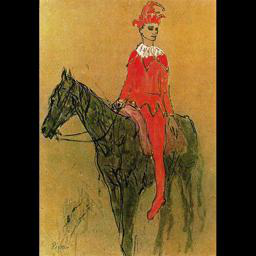

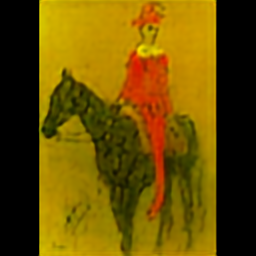

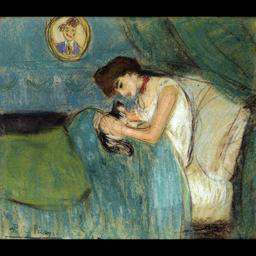

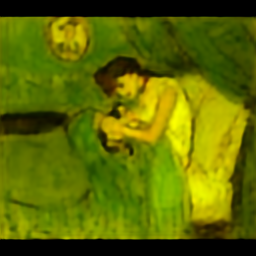

In [7]:
# show the output of reconstruction
from PIL import Image
import numpy as np

for i in range(2):
    original_image = Image.fromarray(X[i])
    original_image_path = 'comparison/original_image.png'
    original_image.save(original_image_path)
    expand = np.expand_dims(X[i], 0)
    reconstruct_output = CAE(expand).numpy().reshape((256, 256, 3))
    output_max = np.max(reconstruct_output)
    output_min = np.min(reconstruct_output)
    reconstruct_output = (reconstruct_output - output_min) / (output_max - output_min) * 255
    reconstruct_output = reconstruct_output.astype(np.uint8)
    reconstruct_image = Image.fromarray(reconstruct_output)
    reconstruct_image_path = 'comparison/reconstruct_image.png'
    reconstruct_image.save(reconstruct_image_path)
    
    show_image(original_image_path)
    show_image(reconstruct_image_path)

In [7]:
# Use the hyperparameter learned from CAE and classify the paints
artists = ['rembrandt', 'pierre-auguste-renoir', 'vincent-van-gogh']

X, y = preprocess_images2(artists=artists, n_imgs=1000, dropout_rate=0.2)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(1350, 256, 256, 3) (1350,)
(150, 256, 256, 3) (150,)


In [8]:
# Implementation for supervised CNN 
# 1. input layer: 3 x 256 x 256
# 2. CONV layer: 100 x 256 x 256 (filter: 5 x 5)
# 3. Maxpooling layer: 2 x 2
# 4. CONV layer: 200 x 128 x 128 (filter: 5 x 5)
# 5. Maxpooling layer: 2 x 2
# 6. Fully connected: 400
# 7. Fully connected: 200
# 8. softmax: 3
# Purpose: Use the hyperparameter learned from the CAE for painter classification

cae_output = Model(inputs = CAE.input, outputs = CAE.layers[-6].output, name = 'cae_output')
for layer in cae_output.layers:
    layer.trainable = False
following_layers = Sequential()
input_shape = (cae_output.output.shape[1], cae_output.output.shape[2], cae_output.output.shape[3])
following_layers.add(tf.keras.layers.Input(shape=input_shape))
following_layers.add(Flatten(name = 'flatten'))
following_layers.add(Dense(400, activation = 'relu', name = "Dense_1"))
following_layers.add(Dense(200, activation = 'relu', name = "Dense_2"))
following_layers.add(Dense(3, activation = 'softmax', name = "softmax"))
painter_classifier = Model(inputs = cae_output.inputs, outputs = following_layers(cae_output.output))
painter_classifier.summary()
painter_classifier.compile(optimizer = 'Adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D_1_input (InputLayer)  [(None, 256, 256, 3)]     0         
_________________________________________________________________
Conv2D_1 (Conv2D)            (None, 256, 256, 100)     7600      
_________________________________________________________________
MaxPool_1 (MaxPooling2D)     (None, 128, 128, 100)     0         
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 128, 128, 200)     500200    
_________________________________________________________________
MaxPool_2 (MaxPooling2D)     (None, 64, 64, 200)       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 3)                 327761203 
Total params: 328,269,003
Trainable params: 327,761,203
Non-trainable params: 507,800
_________________________________________

In [9]:
cae_training_history = painter_classifier.fit(x=X_train, y=y_train, batch_size=32, epochs=15, validation_data=(X_val, y_val))

Epoch 1/15
43/43 [==============================] - 24s 223ms/step - loss: 337.6002 - accuracy: 0.3694 - val_loss: 19.6615 - val_accuracy: 0.6133
Epoch 2/15
43/43 [==============================] - 6s 142ms/step - loss: 24.6417 - accuracy: 0.5370 - val_loss: 10.6337 - val_accuracy: 0.5867
Epoch 3/15
43/43 [==============================] - 6s 141ms/step - loss: 20.6022 - accuracy: 0.5671 - val_loss: 27.9421 - val_accuracy: 0.5467
Epoch 4/15
43/43 [==============================] - 6s 138ms/step - loss: 18.4011 - accuracy: 0.5893 - val_loss: 29.4230 - val_accuracy: 0.5267
Epoch 5/15
43/43 [==============================] - 6s 136ms/step - loss: 32.4621 - accuracy: 0.5513 - val_loss: 16.4500 - val_accuracy: 0.5000
Epoch 6/15
43/43 [==============================] - 6s 135ms/step - loss: 10.3764 - accuracy: 0.6004 - val_loss: 6.7529 - val_accuracy: 0.6200
Epoch 7/15
43/43 [==============================] - 6s 134ms/step - loss: 3.6805 - accuracy: 0.7411 - val_loss: 4.4436 - val_accuracy: 

In [13]:
artists = ['rembrandt', 'pierre-auguste-renoir', 'vincent-van-gogh']

X, y = preprocess_images2(artists=artists, n_imgs=40, test_set=True)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(108, 256, 256, 3) (108,)
(12, 256, 256, 3) (12,)
